# Código base del TFG:
# 'Data Science aplicado a decisiones del Tribunal Constitucional'
## Carlos Ortega Garcia

#### Necesario importar estas librerias para poder ejecutar todo el código:

In [ ]:
#from selenium import webdriver
#import chromedriver_autoinstaller
from bs4 import BeautifulSoup
import glob, re, os, sys, random, textract, requests, time, shutil, nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from random import shuffle

In [ ]:
#Descargar en caso de que no esté instalado en el equipo
nltk.download() #Para poder acceder a la lista de stopwords

## 1. Descarga de sentencias

In [ ]:
i=0
#888 pantallas que navegar dentro de la web
for n in range(889):
    n+=1
    url=f'https://www.tribunalconstitucional.es/es/jurisprudencia/Paginas/resultados-busqueda-sentencias.aspx?pn={n}'

    #Solicitar acceso a la URL y obtener objeto de respuesta Requests URL and get response object
    response = requests.get(url)

    #Parsear el codigo HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    #Encontrar todos los hiperlinks presentes en la web
    links = soup.find_all('a')
    
    #Para cada uno de los hiperlinks, buscar links con formato pdf y descargar el archivo
    for link in links:
        if ('.pdf' in link.get('href', [])):
            i += 1
            print('Descargando archivo: ', i)

            #Obtener el objeto de respuesta
            response = requests.get(link.get('href'))

            #Escribir el contenido en un archivo pdf
            pdf = open('/Users/carlosortega/Desktop/TFG Analytics/PDFs/pdf'+ str(i) + '.pdf', 'wb')
            pdf.write(response.content)
            pdf.close()
            print('Archivo ', i, ' descargado')

## 2. Crear archivos de texto a partir de los archivos PDF

In [ ]:
for i in range(8840): #Número de documentos pdf
    i+=1
    try: #Si da error algun PDF no se detiene el loop
        text = textract.process('/Users/carlosortega/Desktop/TFG Analytics/PDFs/pdf'+ str(i) +'.pdf')
        f = open(os.path.join('/Users/carlosortega/Desktop/TFG Analytics/Textos', str(i) + '.txt'), "wb")
        f.write(text)
        f.close()
    except:
        pass

## 3. Clasificación de sentencias


In [ ]:
sentencias_art = pd.DataFrame({'documento':[],'articulo':[],'tipo_caso':[],'decision':[]})
sentencias_der = pd.DataFrame({'documento':[], 'derecho':[],'tipo_caso':[],'decision':[]})
cases = glob.glob('/Users/carlosortega/Desktop/TFG Analytics/Textos/*.txt')


for case in cases:
    fallo = []
    intro = []
    encabezamiento = []
    articulos = []
    decision = []
    print(case)
    with open(case, 'r') as f:
        
        wr = 0
        starts = 'TRIBUNAL\s*\s*CONSTITUCIONAL|'\
                  'Sala\s*\s*(?:Primera|Segunda).\s*\s*(Sentencia|STC)|'\
                  'Pleno.\s*\s*Sentencia'
        ends = 'SENTENCIA'
        contline=''
        for line in f:    #Busca el encabezamiento de la sentencia
            if wr == 0:
                if re.search(starts, line) != None:  #Encuentra el inicio del encabezamiento
                    encontrado = re.search(starts, line)
                    print('Encontrado' + ' ' + encontrado[0])
                    wr = 1
            if wr == 1 and re.search(ends, line) == None:  #Encuentra el final del encabezamiento
                contline += line
                contline += '\n'
            elif re.search(ends, line) != None:
                break
        encabezamiento.append(contline)
        str_encabezamiento = encabezamiento[0].replace('-','').replace('\n','')
        
        art_escrito = []
        tutela = re.search('tutela\s* judicial\s*', str_encabezamiento)
        igualdad = re.search('derecho.*\s* a\s* la\s* igualdad', str_encabezamiento)
        libertad_personal = re.search('a\s* la\s* libertad\s* personal\s*', str_encabezamiento)
        inocencia = re.search('presunci(?:ó|o)n\s* de\s* inocencia\s*', str_encabezamiento)
        tratos_degradantes = re.search('derecho.*\s* a\s* no\s* ser\s* sometido\s* a\s* torturas\s* ni\s* a\s* tratos\s* inhumanos\s* o\s* degradantes', str_encabezamiento)
        integridad_fisica = re.search('derecho.*\s* a\s* la\s* integridad\s* f(?:í|i)sica', str_encabezamiento)
        proceso_garantias = re.search('proceso\s* con\s* todas\s* las\s* garant(?:í|i)as', str_encabezamiento)
        if tutela != None:
            art_escrito.append('tutela')
        if igualdad != None:
            art_escrito.append('igualdad')
        if libertad_personal != None:
            art_escrito.append('libertad_personal')
        if inocencia != None:
            art_escrito.append('inocencia')
        if tratos_degradantes != None:
            art_escrito.append('tratos_degradantes')
        if integridad_fisica != None:
            art_escrito.append('integridad_fisica')
        if proceso_garantias != None:
            art_escrito.append('proceso_garantias')
        
        print(art_escrito)
        
    with open(case, 'r') as f:
        wr = 0
        starts = 'SENTENCIA'
        ends = 'Antecedentes'
        contline=''
        for line in f:    #Busca parte del encabezamiento de la sentencia
            if wr == 0:
                if re.search(starts, line) != None:  #Encuentra el inicio
                    wr = 1
            if wr == 1 and re.search(ends, line) == None:  #Encuentra el final
                contline += line
                contline += '\n'
            elif re.search(ends, line) != None:
                break
        intro.append(contline)
        
        ab = []
        for line in intro:                  #Busca qué tipo de recurso trata la sentencia
            aa = re.search('((?:R|r)ecurso\s* de\s* inconstitucionalidad|'\
                   '(?:C|c)uesti.*\s* de\s* inconstitucionalidad|'\
                   'demanda de amparo|'\
                   '(?:R|r)ecurso\s* de\s* amparo|'\
                   '(?:C|c)onflicto\s* (?:(positivo) )?\s*\s*de\s* competencia|'\
                   'de\s* amparo\s* [0-9]{1,5}-[0-9]{1,4}|'\
                   'amparo\s* [0-9]{1,5}-[0-9]{1,4}|'\
                   'de\s* inconstitucionalidad\s* [0-9]{1,5}-[0-9]{1,4}|'\
                   'inconstitucionalidad\s* [0-9]{1,5}-[0-9]{1,4})', line)
            if aa != None:
                ab.append(aa[0])
        if not ab:            #Si no hace match, lo dejamos para posterior revision manual
            ab.append('Revisar_tipo_caso')
    
        tipo_caso = re.search('(amparo|inconstitucionalidad|Revisar_tipo_caso|competencia)',ab[0])[0]
        print('Tipo de caso: ' + tipo_caso)
        

        wr = 0
        starts = 'FALLO'
        ends ='Publ(?:í|i)quese\s* esta\s* sentencia\s* en\s* el\s* «Bolet(?:í|i)n\s* Oficial\s* del\s* Estado».'
        contline = ''
        for line in f:    #Busca el FALLO de la sentencia
            if wr == 0:
                if re.search(starts, line) != None:  #Encuentra el inicio del FALLO
                    wr = 1
            if wr == 1 and re.search(ends, line) == None:  #Encuentra el final del FALLO
                contline += line
                contline += '\n'
            elif re.search(ends, line) != None:
                break
        fallo.append(contline)                     
        
        for line in fallo:
            articulo = re.findall('((?:art.*)?\s*[0-9]{1,3}.* (?:CE|Constitución))', line)  # busca todos los articulos de la CE en el FALLO
            articulos.append(articulo)
            
        clean_art = []
        for art in articulos[0]:
            clean = re.search('[0-9]{1,3}.?[0-9]{1,3}', art)
            try:
                clean_art.append(clean[0])
            except:
                pass
        
        clean_art = set(clean_art) #Cogemos una lista de los articulos sin duplicados
        
        if len(clean_art)>4:       #Aquellas sentencias donde se nombren muchos articulos, las dejamos para revision
            clean_art=[]
        
        for line in fallo:
            dec = re.search('(?:E|e)stimar|(?:A|a)dmitir|(?:D|d)enegar\s* el\s* amparo|(?:D|d)esestimar|(?:I|i)nadmitir|(?:O|o)torgar|ha\s* sido\s* vulnerado', line)
            if dec != None:
                decision.append(dec[0])
                break
        if not decision:
            decision.append('Revisar_decision')
            
        print(f'Decision antes: {decision}')
        
        if decision[0].lower() in ['estimar','admitir', 'otorgar']:
            decision = ['Favorable']
        if decision[0].replace(' ', '').lower() in ['desestimar', 'inadmitir', 'hasidovulnerado', 'denegarelamparo']:
            decision = ['Desfavorable']
        
        print(f'Decision despues: {decision}')
        
        path_cwd = '/Users/carlosortega/Desktop/TFG Analytics'
        
        if not clean_art: #Sentencias donde no se detecte ningun articulo
            new_path = path_cwd + '/Articulos' + '/No_articulo_detectado' + '/' + tipo_caso + '/' + decision[0]
            sentencias_art = sentencias_art.append({'documento':re.search('[0-9]{1,4}.*',case[-8:])[0],
                             'articulo':'No_articulo_encontrado',
                             'tipo_caso':tipo_caso,
                             'decision':decision[0]},
                             ignore_index=True)
            print(new_path)
            if not os.path.exists(new_path): #Check por si ese directorio ya existe
                    os.makedirs(new_path)      #Si no, lo creamos

            shutil.copy(case, new_path)
        else:    
            for i in clean_art:
                sentencias_art = sentencias_art.append({'documento':re.search('[0-9]{1,4}.*',case[-8:])[0],
                             'articulo':i,
                             'tipo_caso':tipo_caso,
                             'decision':decision[0]},
                             ignore_index=True)
                print(i)
                new_path = path_cwd + '/Articulos' + '/Articulo' + ' ' + i + '/' + tipo_caso + '/' + decision[0]
                print(new_path)
                if not os.path.exists(new_path): #Check por si ese directorio ya existe
                    os.makedirs(new_path)      #Si no, lo creamos

                shutil.copy(case, new_path)
        if not not art_escrito:
            for derecho in art_escrito:
                new_path = path_cwd + '/Articulos' + '/' + derecho + '/' + tipo_caso + '/' + decision[0]
                sentencias_der = sentencias_der.append({'documento':re.search('[0-9]{1,4}.*',case[-8:])[0],
                             'derecho': derecho,
                             'tipo_caso':tipo_caso,
                             'decision':decision[0]},
                             ignore_index=True)
                print(new_path)
                if not os.path.exists(new_path): #Check por si ese directorio ya existe
                        os.makedirs(new_path)      #Si no, lo creamos

                shutil.copy(case, new_path)

### Clasificación por número de artículo en el FALLO

In [192]:
sentencias_art[sentencias_art.articulo!='No_articulo_encontrado'].groupby(['articulo','tipo_caso','decision']).documento.count().sort_values(ascending=False).head(30)

articulo  tipo_caso             decision    
24.1      amparo                Favorable       856
24.2      amparo                Favorable       328
14        amparo                Favorable       179
24.1      amparo                Desfavorable    129
23.2      amparo                Favorable       101
17.1      amparo                Favorable        74
24        amparo                Favorable        73
25.1      amparo                Favorable        58
14        amparo                Desfavorable     56
23        amparo                Favorable        53
28.1      amparo                Favorable        43
149.1     inconstitucionalidad  Favorable        40
9.3       inconstitucionalidad  Desfavorable     40
24.2      amparo                Desfavorable     39
24.1      Revisar_tipo_caso     Favorable        35
20.1      amparo                Favorable        35
24        amparo                Desfavorable     34
22        amparo                Favorable        32
149.1     inconstit

In [35]:
recuento_sentencias[recuento_sentencias.documento>30].groupby(['articulo','tipo_caso']).agg({'documento':['count',
                                                                                                          'min',
                                                                                                          'max']})

documento          
                                  count  min  max
articulo tipo_caso                               
14       amparo                       2   47  169
149.1    inconstitucionalidad         1   35   35
17.1     amparo                       1   70   70
20.1     amparo                       1   34   34
23       amparo                       1   53   53
23.2     amparo                       1   98   98
24       amparo                       2   31   68
24.1     Revisar_tipo_caso            1   35   35
         amparo                       2  120  842
24.2     amparo                       2   32  316
25.1     amparo                       1   55   55
28.1     amparo                       1   41   41
9.3      inconstitucionalidad         1   37   37

### Clasificación por vulneración mencionada en el ENCABEZAMIENTO

In [193]:
sentencias_der[(sentencias_der.derecho.isin(['tutela','igualdad','inocencia']))&
               (sentencias_der.tipo_caso=='amparo')&
               (sentencias_der.decision!='Revisar_decision')].groupby(['derecho','tipo_caso','decision']).documento.count()

derecho    tipo_caso  decision    
igualdad   amparo     Desfavorable     178
                      Favorable        114
inocencia  amparo     Desfavorable     130
                      Favorable        146
tutela     amparo     Desfavorable     649
                      Favorable       1146
Name: documento, dtype: int64

Unicamente crearé modelos para la combinación de artículo-tipo de caso que tenga un dataset con suficientes casos tanto 'Favorables' como 'Desfavorables'

Articulo:
- Artículo 14 (recurso de amparo)
- Artículo 24.1 (recurso de amparo)
- Artículo 24.2 (recurso de amparo)

Derecho:
- Tutela judicial efectiva (recurso de amparo)
- Igualdad (recurso de amparo)
- Presunción inocencia (recurso de amparo)

## 4. Balanced dataset


Training set:
- Coger la categoria con menos casos como número de referencia. Split del 80% entre train set y test set.

Test set:
- Probar tanto:
    - Balanced test set
    - Unbalanced test set --> No medir accuracy sino sensitividad y especificidad

In [8]:
import random

articulos_mod = ['tutela', 'igualdad', 'inocencia'] #Carpetas de sentencias sobre las que se creará el modelo
caso_mod = 'amparo'


for art in articulos_mod:
    print(f'{art}:')
    #Creo las carpetas para separar las sentencias que se usarán para entrenamiento y para test
    for decision in ['Favorable', 'Desfavorable']:

        new_path_train = '/Users/carlosortega/Desktop/TFG Analytics/train/' + art + '/' + caso_mod + '/' + decision 
        new_path_test = '/Users/carlosortega/Desktop/TFG Analytics/test/' + art + '/' +  caso_mod + '/' + decision 

        os.makedirs(new_path_train)
        os.makedirs(new_path_test)
    
    #Cogemos todos los casos favorables y desfavorables para cada artículo
    casos_fav = glob.glob(f'/Users/carlosortega/Desktop/TFG Analytics/Articulos/{art}/{caso_mod}/Favorable/*.txt')
    casos_desfav = glob.glob(f'/Users/carlosortega/Desktop/TFG Analytics/Articulos/{art}/{caso_mod}/Desfavorable/*.txt')    
    
    #Añadir las sentencias del Articulo 24 a las de los Articulos 24.1 y 24.2
    #if art in ['Articulo 24.1', 'Articulo 24.2']:
    #    casos_fav += glob.glob(f'/Users/carlosortega/Desktop/TFG Analytics/Articulos/Articulo 24/{caso_mod}/Favorable/*.txt')
    #    casos_desfav += glob.glob(f'/Users/carlosortega/Desktop/TFG Analytics/Articulos/Articulo 24/{caso_mod}/Desfavorable/*.txt')    
        
    print(f'{len(casos_fav)} casos favorables \n{len(casos_desfav)} casos desfavorables\n')
    
    min_casos = min([len(casos_fav),len(casos_desfav)])
    train_n = round(min_casos*0.8)  #Numero de sentencias de cada categoría (Favorable o Desfavorable) para entrenar el modelo
    test_n = min_casos-train_n
    
    #Seleccionamos aleatoriamente las sentencias
    random.seed(100)
    casos_fav_train = random.sample(casos_fav,train_n)
    random.seed(100)
    casos_desfav_train = random.sample(casos_desfav,train_n)
    
    #Test set 'balanced' para cross-validation:
    
    casos_fav_test = random.sample([x for x in casos_fav if x not in casos_fav_train],test_n)
    casos_desfav_test = random.sample([x for x in casos_desfav if x not in casos_desfav_train],test_n)
    print(f'\tCasos a utilizar empleando cross-validation: \n\t\t{len(casos_fav_train)+len(casos_fav_test)} favorables\n\t\t{len(casos_desfav_train)+len(casos_desfav_test)} desfavorables\n')
    
    #Test set 'unbalanced':
    
    #casos_fav_test = [x for x in casos_fav if x not in casos_fav_train]
    #casos_desfav_test = [x for x in casos_desfav if x not in casos_desfav_train]
    #print(f'\tCasos entrenamiento: \n\t\t{len(casos_fav_train)} favorables\n\t\t{len(casos_desfav_train)} desfavorables\n')
    #print(f'\tCasos test: \n\t\t{len(casos_fav_test)} favorables\n\t\t{len(casos_desfav_test)} desfavorables\n\n')

    
    new_path_fav_train = '/Users/carlosortega/Desktop/TFG Analytics/train/' + art + '/' + caso_mod + '/Favorable'
    for caso in casos_fav_train:
        shutil.copy(caso, new_path_fav_train)
    
    new_path_fav_test = '/Users/carlosortega/Desktop/TFG Analytics/test/' + art + '/' + caso_mod + '/Favorable' 
    for caso in casos_fav_test:
        shutil.copy(caso, new_path_fav_test)
        
    new_path_desfav_train = '/Users/carlosortega/Desktop/TFG Analytics/train/' + art + '/' + caso_mod + '/Desfavorable/'
    for caso in casos_desfav_train:
        shutil.copy(caso, new_path_desfav_train)
    
    new_path_desfav_test = '/Users/carlosortega/Desktop/TFG Analytics/test/' + art + '/' + caso_mod + '/Desfavorable/'
    for caso in casos_desfav_test:
        shutil.copy(caso, new_path_desfav_test)

tutela:
1146 casos favorables 
649 casos desfavorables

	Casos a utilizar empleando cross-validation: 
		649 favorables
		649 desfavorables

igualdad:
114 casos favorables 
178 casos desfavorables

	Casos a utilizar empleando cross-validation: 
		114 favorables
		114 desfavorables

inocencia:
146 casos favorables 
130 casos desfavorables

	Casos a utilizar empleando cross-validation: 
		130 favorables
		130 desfavorables



## 5. Pipeline del modelo

A través de este pipeline:

- Extraeremos cada parte de las sentencias
- Entrenaremos el modelo:

    - k-fold cross validation:
        - Distinta k para cada artículo (en base a su volumen).
        - Balanced test set

    - Simple training:
        - Balanced o unbalanced test set
        - Sacaremos las 30 variables con mayor peso

- Validaremos el modelo con el test set
- Evaluaremos el modelo con distintas métricas

In [46]:
def extract_text(starts, ends, cases, violation):
    facts = []
    D = []
    years = []
    for case in cases:
        contline = ''
        year = 0
        with open(case, 'r') as f:
            for line in f:
                dat = re.search(r'\b\d{4}\b', line) #Buscar el año de la sentencia
                if dat != None:
                    year = int(dat[0])
                    break
            if year>0:
                years.append(year)
                wr = 0
                for line in f:
                    if wr == 0:
                        if re.search(starts, line) != None:
                            wr = 1
                    if wr == 1 and re.search(ends, line) == None:
                        contline += line
                        contline += '\n'
                    elif re.search(ends, line) != None:
                        break
                facts.append(contline)
    for i in range(len(facts)):
        D.append((facts[i], violation, years[i])) 
    return D

In [47]:
def extract_parts(train_path, violation, part): #Establecer el fin e inicio de cada parte de la sentencia
    cases = glob.glob(train_path)

    facts = []
    D = []
        
    if part == 'intro+composicion_tribunal':
        starts = 'TRIBUNAL\s*\s*CONSTITUCIONAL|'\
                  'Sala\s*\s*(?:Primera|Segunda).\s*\s*(Sentencia|STC)|'\
                  'Pleno.\s*\s*Sentencia'
        ends ='SENTENCIA'
        D = extract_text(starts, ends, cases, violation)
    if part == 'contexto':
        starts = 'SENTENCIA'
        ends ='Antecedentes'
        D = extract_text(starts, ends, cases, violation)
    if part == 'antecedentes':
        starts = 'Antecedentes'
        ends ='Fundamentos jur(?:í|i)dicos'
        D = extract_text(starts, ends, cases, violation)
    if part == 'fundamentos':
        starts = 'Fundamentos jur(?:í|i)dicos'
        ends ='FALLO'
        D = extract_text(starts, ends, cases, violation)
    if part == 'antecedentes+fundamentos':
        starts = 'Antecedentes'
        ends ='FALLO'
        D = extract_text(starts, ends, cases, violation)
    if part == 'todo':
        starts = 'TRIBUNAL\s*\s*CONSTITUCIONAL|'\
                  'Sala\s*\s*(?:Primera|Segunda).\s*\s*(Sentencia|STC)|'\
                  'Pleno.\s*\s*Sentencia'
        ends = 'FALLO'
        D = extract_text(starts, ends, cases, violation)
    return D

In [214]:
def train_model_cross_val(Xtrain, Ytrain, Xtest, Ytest, vec, c): #Linear SVC aplicando cross-validation
    print(f'***Haciendo {k}-fold cross-validation***')
    pipeline = Pipeline([
        ('features', FeatureUnion(
            [vec],
        )),
        ('classifier', LinearSVC(C=c))
        ])
    
    X = Xtrain + Xtest
    Y = Ytrain + Ytest
    
    Ypredict = cross_val_predict(pipeline, X, Y, cv=k) #k-fold cross-validation
    evaluate(Y, Ypredict)

In [201]:
def train_model_test(Xtrain, Ytrain, Xtest, Ytest, vec, c):
    
    #Pipeline para encadenar los distintos steps que debe llevar a cabo el modelo
    pipeline = Pipeline([
        ('features', FeatureUnion([vec]
        )),
        ('classifier', LinearSVC(C=c))
        ])
    
    #Entrenamiento del modelo
    pipeline.fit(Xtrain, Ytrain)
    print('***TEST***')
    
    #Test sobre datos nuevos
    Ypredict = pipeline.predict(Xtest)
    
    print(pipeline.classes_) #
    
    #Feature importance
    
    #Extraigo la información sobre el feature importance
    variables = pipeline.named_steps['features'].get_feature_names()
    coeficientes = pipeline.named_steps['classifier'].coef_.flatten()
    
    #Dataframe agrupando variables y sus coeficientes
    zipped = zip(variables, coeficientes)
    df_variables = pd.DataFrame(zipped, columns=["feature", "value"])
    
    #Establecemos olor rojo para coeficientes negativos y verde para positivos
    df_variables["colors"] = df_variables["value"].apply(lambda x: "green" if x > 0 else "red")
    
    #Ordenamos las variables por el valor absoluto de su coeficiente
    df_variables["abs_value"] = df_variables["value"].apply(lambda x: abs(x))
    df_variables = df_variables.sort_values("abs_value", ascending=False)
    df_variables.loc[:,'feature'] = df_variables.feature.str[9:]
    
    #Gráfico
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x="feature",
                y="value",
                data=df_variables.head(30),
               palette=df_variables.head(30)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 30 Variables", fontsize=25)
    ax.set_ylabel("Coeficiente", fontsize=22)
    plt.show()
    
    evaluate(Ytest, Ypredict)

In [167]:
def evaluate(Ytest, Ypredict): #Evaluar el modelo (accuracy, precision, recall, f-score, confusion matrix, AUC)
    
    #Métricas de evaluación de la performance del modelo sobre las predicciones realizadas
    
    print('Accuracy:', accuracy_score(Ytest, Ypredict) )
    print('\nClassification report:\n', classification_report(Ytest, Ypredict))
    print('\nMatriz de confusion:\n', confusion_matrix(Ytest, Ypredict))

    #Curva ROC (grafico)

    #fpr --> false-positive-rate
    #tpr --> true-positive-rate

    fpr, tpr, _ = metrics.roc_curve(Ytest, Ypredict)
    auc_score = metrics.auc(fpr, tpr)
    
    print('\nAUC:\n', auc_score)
    
    fig = plt.subplots(figsize=(9,13))

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {round(auc_score,3)}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    #Matriz de confusion (grafico)
    
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(Ytest, Ypredict), annot=True, fmt='g', ax=ax) #annot=True para ver los valores de cada celda y fmt='g' para evitar notación científica

    ax.set_xlabel('Etiqueta predicha')
    ax.set_ylabel('Etiqueta real')
    ax.set_title('Matriz de Confusión')
    ax.xaxis.set_ticklabels(['Desfavorable', 'Favorable'])
    ax.yaxis.set_ticklabels(['Desfavorable', 'Favorable'])
    ax.yaxis.set_tick_params(rotation=0)
    plt.show()

    print('\n\n_______________________\n\n')

In [220]:
def run_pipeline(parte, articulo, vec, c): #run tests
    
    print('Entrenando sobre: ' + parte + '\n')
    
    #Sentencias para entrenamiento
    train_fav = extract_parts(path+'train/'+articulo+'/amparo/Favorable/*.txt', 1, parte)
    train_desfav = extract_parts(path+'train/'+articulo+'/amparo/Desfavorable/*.txt', 0, parte)
    trainset = train_fav+train_desfav
    shuffle(trainset)

    Xtrain = [i[0] for i in trainset]
    Ytrain = [i[1] for i in trainset]
    
    #Sentencias para test
    test_fav = extract_parts(path+'test/'+articulo+'/amparo/Favorable/*.txt', 1, parte)
    test_desfav = extract_parts(path+'test/'+articulo+'/amparo/Desfavorable/*.txt', 0, parte)
    testset = test_fav+test_desfav
    shuffle(testset)
    
    Xtest = [i[0] for i in testset]
    Ytest = [i[1] for i in testset]

    if cv: #Si elegimos aplicar cross validation
        print('Aplicando cross validation sobre', Ytrain.count(1)+Ytest.count(1),'casos favorables +', Ytrain.count(0)+Ytest.count(0), 'casos desfavorables =', Ytrain.count(1)+Ytest.count(1) + Ytrain.count(0)+Ytest.count(0), 'casos en total')
        train_model_cross_val(Xtrain, Ytrain, Xtest, Ytest, vec, c) #use for cross-validation
    
    else: #Si decidimos entrenar el modelo sin cross validation
        print('Entrenando sobre', Ytrain.count(1),'casos favorables +', Ytrain.count(0), 'casos desfavorables =', Ytrain.count(1) + Ytrain.count(0), 'casos', '\nSentencias disponibles para testear:', Ytest.count(1), 'favorables +', Ytest.count(0),' desfavorables')
        train_model_test(Xtrain, Ytrain, Xtest, Ytest, vec, c)

In [ ]:
def ejecutar_grid_search(Xtrain, Ytrain):

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word')),
        ('clf', LinearSVC())
        ])
    
    #Distintos parámetros a optimizar
    #con distintos valores a probar
    parameters = { 
    'tfidf__ngram_range': [(1,2),(1,1),(1,3),(1,4),(2,2),(2,3),(2,4),(3,3),(3,4),(4,4)],
    'tfidf__lowercase': (True, False),
    #'tfidf__max_df': (0.01, 1.0), # ignore words that occur as more than 1% of corpus
    #'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice)
    'tfidf__use_idf': (False, True),
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True),
    'tfidf__norm': (None, 'l1', 'l2'),
    'tfidf__max_features': (None, 2000, 5000),
    'tfidf__stop_words': (None, stopwords.words('spanish')),
    #'tfidfchar_ngram_range': ((1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(2,2),(2,3),(2,4),(2,5),(2,6),(3,3),(3,4),(3,5),(3,6),(4,4),(4,5),(4,6),(5,5),(5,6),(1,7),(2,7),(3,7),(4,7),(5,7),(6,7),(7,7)),
    'clf__C':(0.1, 1, 5)
}
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=24, verbose=1)
    grid_search.fit(Xtrain, Ytrain)

    print(f'Mejor resultado: {round(grid_search.best_score_,3)}')
    print('Mejor conjunto de parametros:')

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f'\t{param_name}: {best_parameters[param_name]}')

### 

## 6. Modelos para cada artículo y para cada parte de la sentencia (Training + Validation)

En este caso estoy probando un test set unbalanced, otras variantes que he probado han sido:
- Balanced test set
- Balanced test set incluyendo las sentencias del artículo 24 a los datasets de los artículos 24.1 y 24.2
- Balanced test set probando cross validation


Nota: No uso los fundamentos jurídicos ya que esa parte de la sentencia contiene información sobre el veredicto final

### Modelo usando cross-validation

tutela
_________________
_________________

Entrenando sobre: antecedentes

Aplicando cross validation sobre 649 casos favorables + 649 casos desfavorables = 1298 casos en total
***Haciendo 10-fold cross-validation***
Accuracy: 0.7164869029275809

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       649
           1       0.70      0.75      0.72       649

    accuracy                           0.72      1298
   macro avg       0.72      0.72      0.72      1298
weighted avg       0.72      0.72      0.72      1298


Matriz de confusion:
 [[445 204]
 [164 485]]

AUC:
 0.7164869029275809


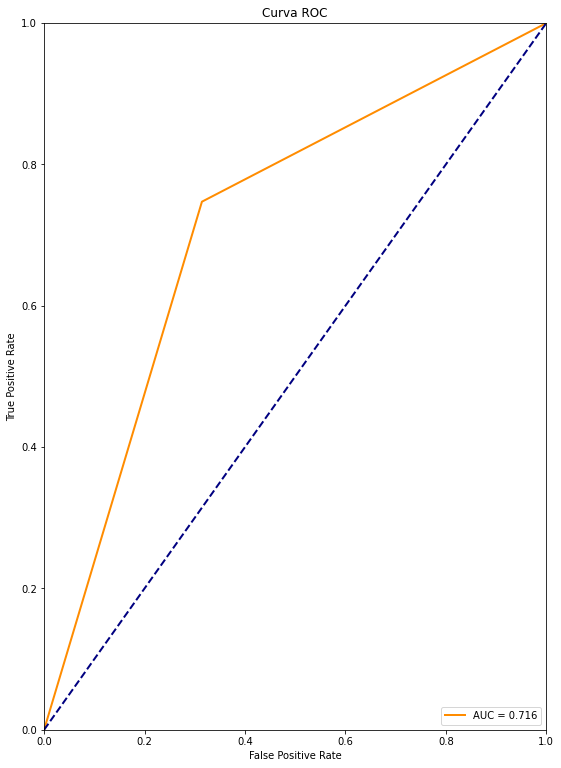

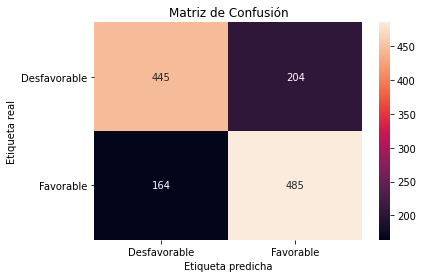



_______________________


igualdad
_________________
_________________

Entrenando sobre: antecedentes

Aplicando cross validation sobre 114 casos favorables + 114 casos desfavorables = 228 casos en total
***Haciendo 5-fold cross-validation***
Accuracy: 0.7982456140350878

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.81       114
           1       0.83      0.75      0.79       114

    accuracy                           0.80       228
   macro avg       0.80      0.80      0.80       228
weighted avg       0.80      0.80      0.80       228


Matriz de confusion:
 [[96 18]
 [28 86]]

AUC:
 0.7982456140350878


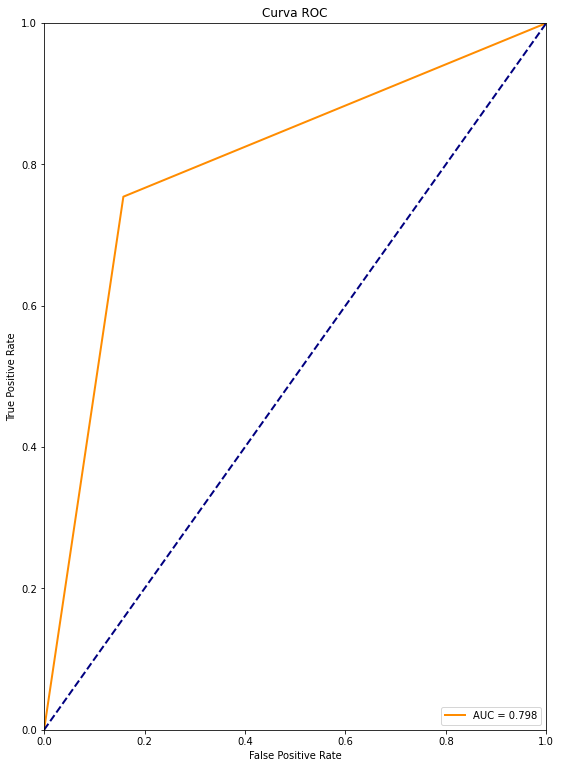

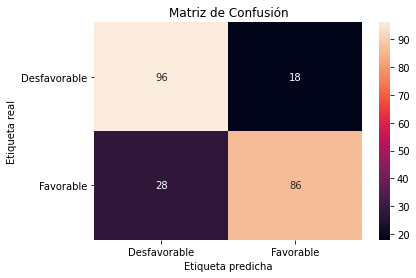



_______________________


inocencia
_________________
_________________

Entrenando sobre: antecedentes

Aplicando cross validation sobre 130 casos favorables + 130 casos desfavorables = 260 casos en total
***Haciendo 5-fold cross-validation***
Accuracy: 0.7230769230769231

Classification report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75       130
           1       0.78      0.62      0.69       130

    accuracy                           0.72       260
   macro avg       0.73      0.72      0.72       260
weighted avg       0.73      0.72      0.72       260


Matriz de confusion:
 [[107  23]
 [ 49  81]]

AUC:
 0.7230769230769231


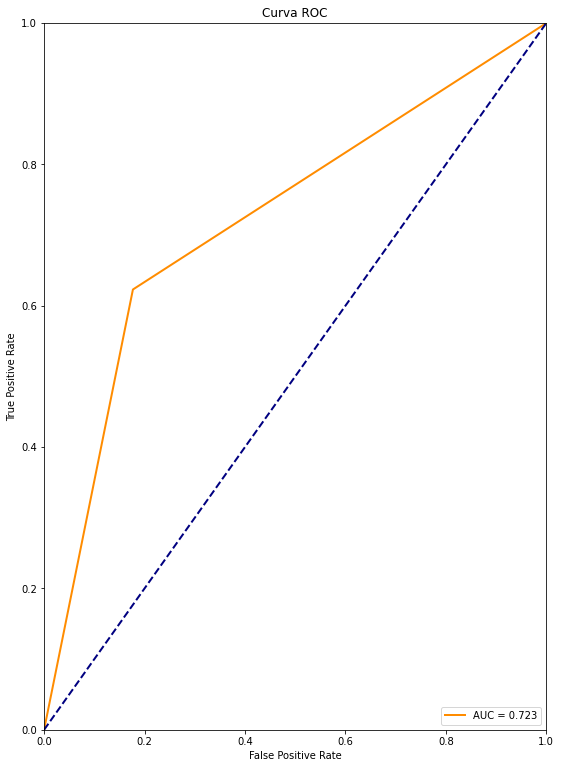

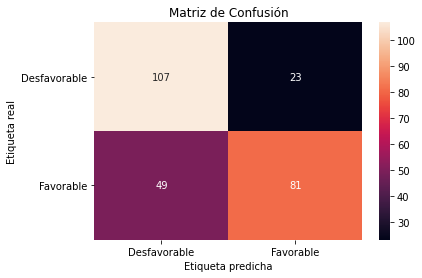



_______________________




In [28]:
stop_words = stopwords.words('spanish') + ['justicia', 'laudo', 'edictos', 'recurrentes','actuaciones','inmediatamente', 'preparación', 'arto', 'prueba', 'notificación']
articulos = ['tutela', 
            'igualdad',
            'inocencia']#,
            #'Articulo 24.1',
            #'Articulo 24.2',
            #'Articulo 14']

partes_sentencia = ['antecedentes']
                    #'intro+composicion_tribunal',
                    #'contexto',
                    #'fundamentos',
                    #'antecedentes+fundamentos',
                    #'todo']


if __name__ == "__main__":
    
    #Indicar ruta donde se encuentran los datos
    path = '/Users/carlosortega/Desktop/TFG Analytics/'
    
    for articulo in articulos:
        print (articulo + '\n_________________\n_________________\n')
        if articulo=='tutela':
            for parte in partes_sentencia:
                vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = True, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = None, use_idf = True))
                c = 0.1
                cv = True #Flag para activar cross validation
                k = 10 #Numero de folds para cv
                run_pipeline(parte, articulo, vec, c)
        if articulo=='igualdad':
            for parte in partes_sentencia:
                vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = True, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = None, use_idf = True))
                c = 0.1
                cv = True #Flag para activar cross validation                
                k = 5
                run_pipeline(parte, articulo, vec, c)
        if articulo=='inocencia':
            for parte in partes_sentencia:
                vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = True, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = None, use_idf = True))
                c = 0.1
                cv = True #Flag para activar cross validation                
                k = 5
                run_pipeline(parte, articulo, vec, c)



### Modelo sin cross-validation y con Feature Importance

tutela
_________________
_________________

Entrenando sobre: antecedentes

Entrenando sobre 519 casos favorables + 519 casos desfavorables = 1038 casos 
Sentencias disponibles para testear: 130 favorables + 130  desfavorables
***TEST***
[0 1]


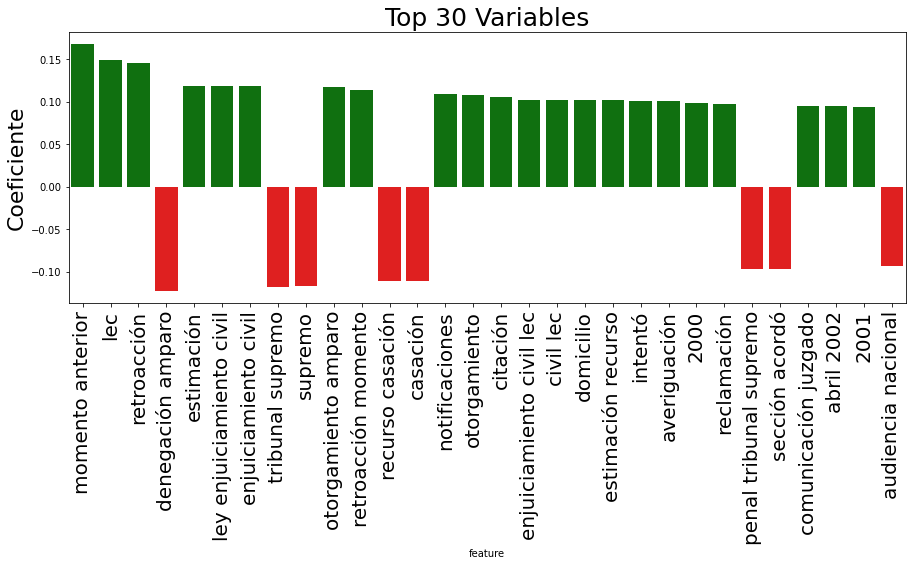

Accuracy: 0.7576923076923077

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       130
           1       0.75      0.78      0.76       130

    accuracy                           0.76       260
   macro avg       0.76      0.76      0.76       260
weighted avg       0.76      0.76      0.76       260


Matriz de confusion:
 [[ 96  34]
 [ 29 101]]

AUC:
 0.7576923076923078


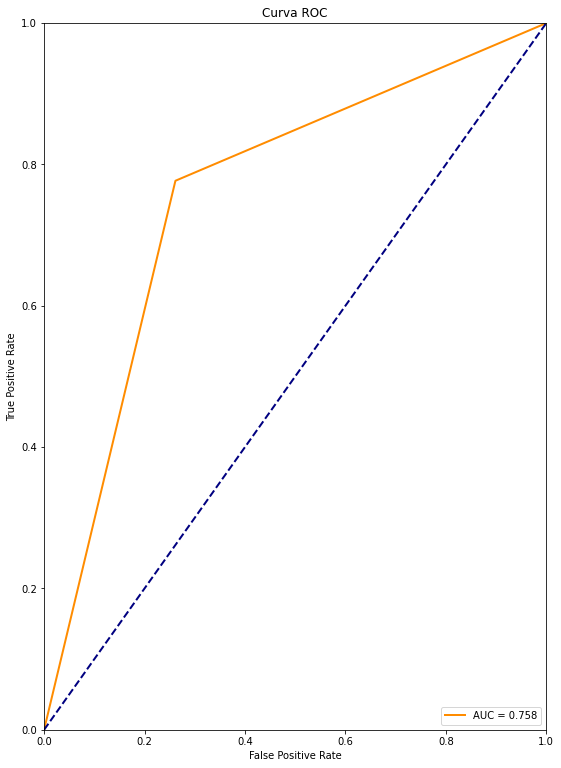

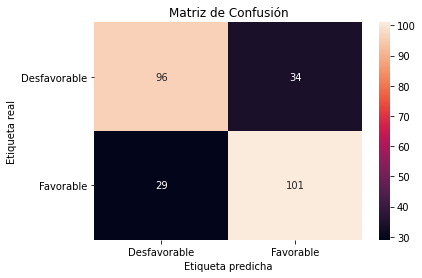



_______________________


igualdad
_________________
_________________

Entrenando sobre: antecedentes

Entrenando sobre 91 casos favorables + 91 casos desfavorables = 182 casos 
Sentencias disponibles para testear: 23 favorables + 23  desfavorables
***TEST***
[0 1]


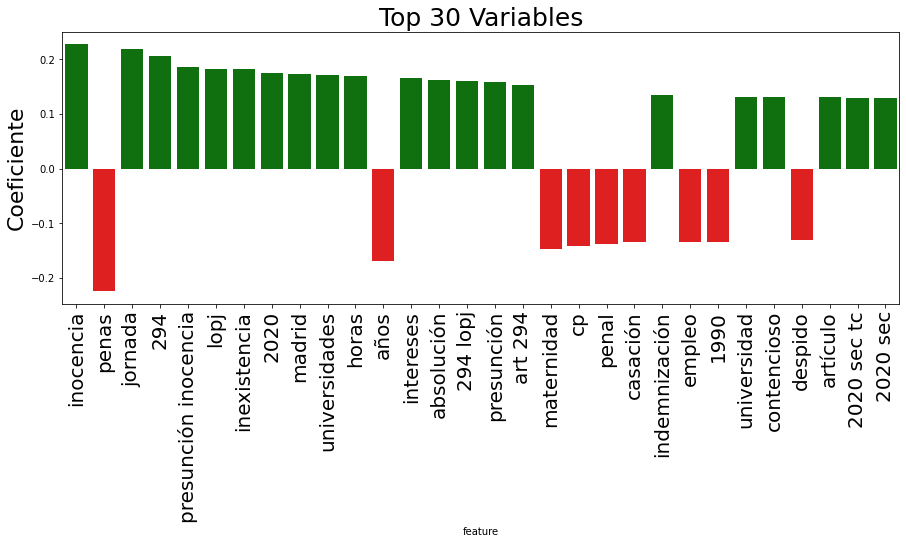

Accuracy: 0.7608695652173914

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       0.73      0.83      0.78        23

    accuracy                           0.76        46
   macro avg       0.77      0.76      0.76        46
weighted avg       0.77      0.76      0.76        46


Matriz de confusion:
 [[16  7]
 [ 4 19]]

AUC:
 0.7608695652173914


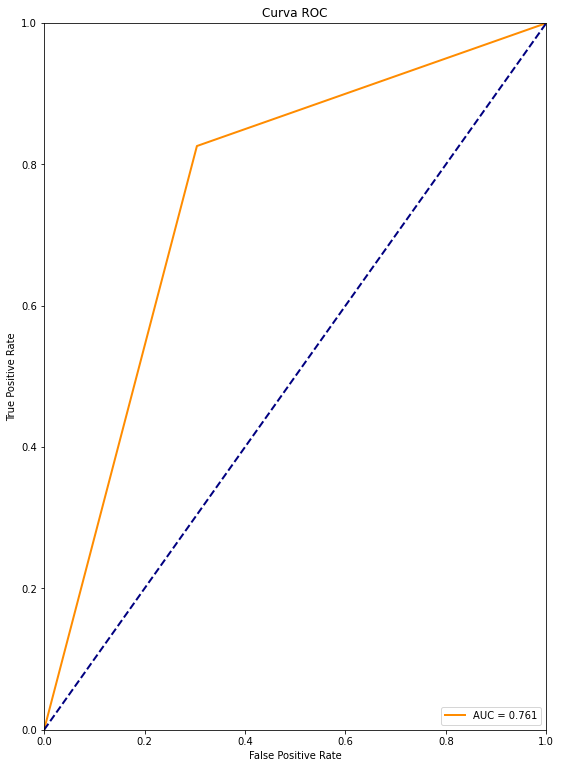

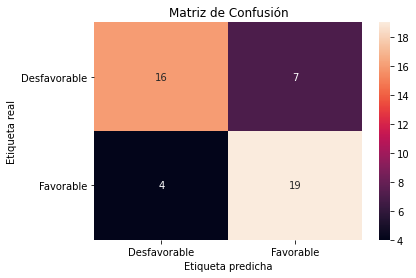



_______________________


inocencia
_________________
_________________

Entrenando sobre: antecedentes

Entrenando sobre 104 casos favorables + 104 casos desfavorables = 208 casos 
Sentencias disponibles para testear: 26 favorables + 26  desfavorables
***TEST***
[0 1]


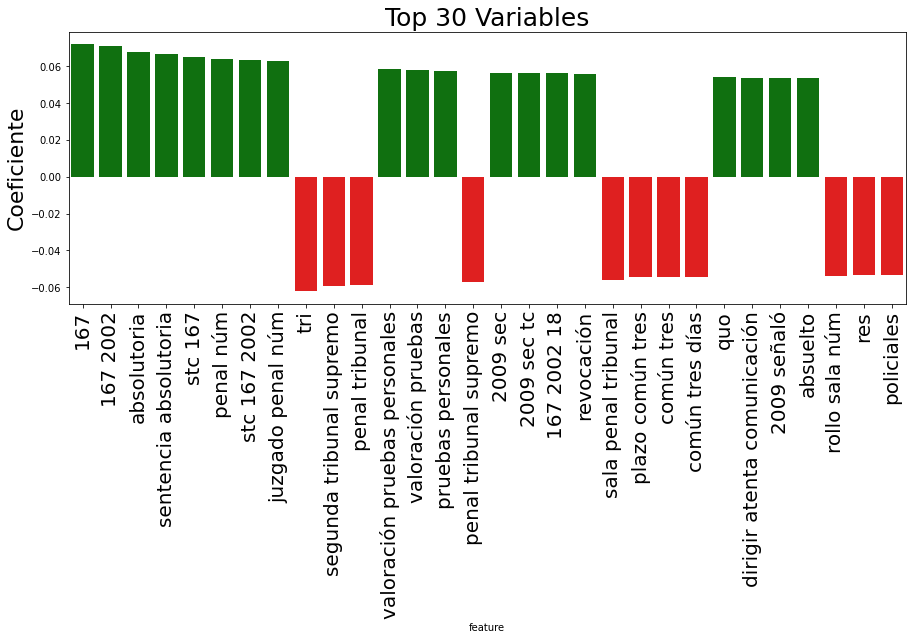

Accuracy: 0.7884615384615384

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.81        26
           1       0.89      0.65      0.76        26

    accuracy                           0.79        52
   macro avg       0.81      0.79      0.78        52
weighted avg       0.81      0.79      0.78        52


Matriz de confusion:
 [[24  2]
 [ 9 17]]

AUC:
 0.7884615384615384


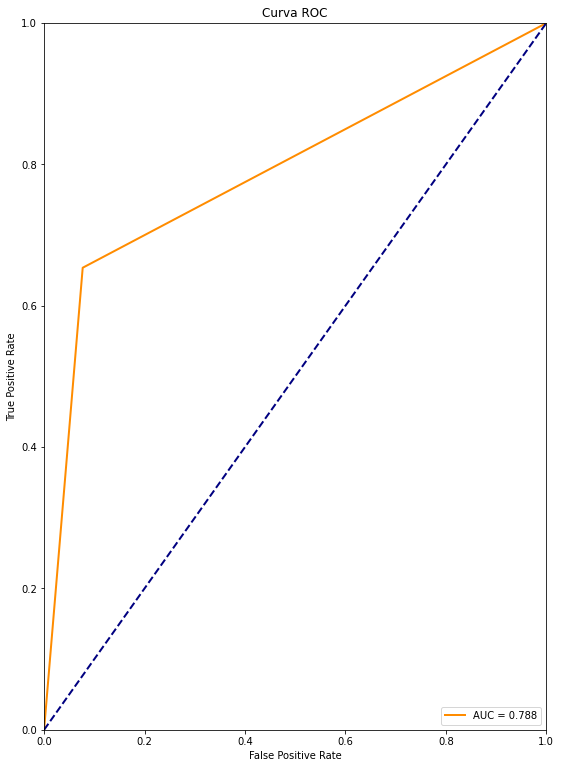

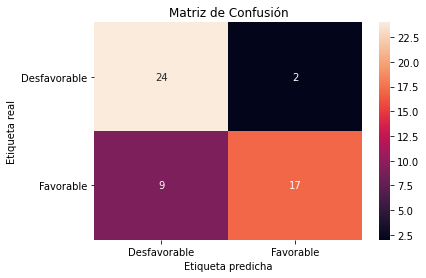



_______________________




In [15]:
stop_words = stopwords.words('spanish') + ['justicia', 'laudo', 'edictos', 'recurrentes','actuaciones','inmediatamente', 'preparación', 'arto', 'prueba', 'notificación']
articulos = ['tutela', 
            'igualdad',
            'inocencia']#,
            #'Articulo 24.1',
            #'Articulo 24.2',
            #'Articulo 14']

partes_sentencia = ['antecedentes']
                    #'intro+composicion_tribunal',
                    #'contexto',
                    #'fundamentos',
                    #'antecedentes+fundamentos',
                    #'todo']

if __name__ == "__main__":
    
    #Indicar ruta donde se encuentran los datos
    path = '/Users/carlosortega/Desktop/TFG Analytics/'
    
    for articulo in articulos:
        print (articulo + '\n_________________\n_________________\n')
        if articulo=='tutela':
            for parte in partes_sentencia:
                vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = True, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = stop_words, use_idf = True))
                c = 0.1
                cv = False #Flag para activar cross validation
                k = 10 #Numero de folds para cv
                run_pipeline(parte, articulo, vec, c)
        if articulo=='igualdad':
            for parte in partes_sentencia:
                vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = False, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = stop_words, use_idf = True))
                c = 0.1
                cv = False #Flag para activar cross validation                
                k = 5
                run_pipeline(parte, articulo, vec, c)
        if articulo=='inocencia':
            for parte in partes_sentencia:
                vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (1,3), binary = True, lowercase = True, max_df = 0.9, min_df = 2, norm = 'l2', stop_words = stop_words, use_idf = True))
                c = 0.1
                cv = False #Flag para activar cross validation                
                k = 5
                run_pipeline(parte, articulo, vec, c)
